In [1]:
  '''
Build a LSTM model to perform sentiment analysis on IMDB dataset.
Save the model to the disk for further analysis.
'''
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [2]:
VOCAB_SIZE = 10000
PAD_VALUE = 0
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_SEQ_LEN = 256
WORD_VEC_DIMS = 50
LSTM_UNITS = 64
word_index = {}
reverse_word_index = {}

In [3]:
input_seq = tf.placeholder(tf.int32, [None, MAX_SEQ_LEN], name='input_seq')
target_class = tf.placeholder(tf.float32, [None, 1], name='target_class')

In [4]:
def loadData():
    imdb = keras.datasets.imdb

    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

    train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
    test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

    valid_data = train_data[0:5000]
    valid_labels = train_labels[0:5000]

    train_data = train_data[5000:]
    train_labels = train_labels[5000:]

    return imdb, train_data, train_labels, valid_data, valid_labels, test_data, test_labels

In [5]:
def decodeExampleText(imdb, text):
    '''
    for given text, returns decoded form.
    numbers=>words
    '''
    global word_index
    global reverse_word_index
    word_index = imdb.get_word_index()
    # The first indices are reserved
    word_index = {k:(v+3) for k,v in word_index.items()} 
    word_index["<PAD>"] = PAD_VALUE
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown
    word_index["<UNUSED>"] = 3

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
def preprocessData(train_data, valid_data, test_data):
    '''
    pad the arrays so they all have the same length,
    then create an integer tensor of shape max_length * num_reviews.
    we can use an embedding layer capable of handling this shape as the first layer in our network.
    '''

    train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    valid_data = keras.preprocessing.sequence.pad_sequences(valid_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    
    train_data = np.reshape(train_data, (train_data.shape[0], MAX_SEQ_LEN))
    valid_data = np.reshape(valid_data, (valid_data.shape[0], MAX_SEQ_LEN))
    test_data = np.reshape(test_data, (test_data.shape[0], MAX_SEQ_LEN))

    return train_data, valid_data, test_data

In [7]:
def buildModel():
    '''
    returns output, cost and optimizer as tensor ops.
    '''
    # embedding layer
    word_vec = tf.Variable(tf.truncated_normal([VOCAB_SIZE, WORD_VEC_DIMS]), dtype=tf.float32, name='Word-Vectors')
    input_vec = tf.nn.embedding_lookup(word_vec, input_seq)

    # rnn lstm layer
    rnn_cell = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    rnn_cell = tf.contrib.rnn.DropoutWrapper(cell=rnn_cell, output_keep_prob=0.5)

    # finally, the rnn put together
    output, _ = tf.nn.dynamic_rnn(rnn_cell, input_vec, dtype=tf.float32)
    
    output = tf.layers.flatten(output)

    output = tf.layers.dense(output, 32)
    output = tf.nn.relu(output)

    output = tf.layers.dense(output, 1)
    output = tf.nn.sigmoid(output)
    # prediction = tf.constant(output, name='prediction')

    train_summaries = []
    valid_summaries = []

    loss = tf.losses.sigmoid_cross_entropy(target_class, output)
    train_summaries.append(tf.summary.scalar('Training-Loss', loss))
    valid_summaries.append(tf.summary.scalar('Validation-Loss', loss))

    optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    # a list of metrics to measure accuracy, precision, recall, f1-score
    metrics = []

    round_output = tf.round(output)
    
    accuracy = tf.metrics.accuracy(target_class, round_output, name='Accuracy')
    train_summaries.append(tf.summary.scalar('Training-Accuracy', accuracy[0]))
    valid_summaries.append(tf.summary.scalar('Validation-Accuracy', accuracy[0]))

    precision = tf.metrics.precision(target_class, round_output, name='Precision')
    train_summaries.append(tf.summary.scalar('Training-Precision', precision[0]))
    valid_summaries.append(tf.summary.scalar('Validation-Precision', precision[0]))

    recall = tf.metrics.recall(target_class, round_output, name='Recall')
    train_summaries.append(tf.summary.scalar('Training-Recall', recall[0]))
    valid_summaries.append(tf.summary.scalar('Validation-Recall', recall[0]))

    metrics.append(accuracy)
    metrics.append(precision)
    metrics.append(recall)

    return optimizer, loss, output, metrics, train_summaries, valid_summaries

In [8]:
imdb, train_x, train_y, valid_x, valid_y, test_x, test_y = loadData()
train_x, valid_x, test_x = preprocessData(train_x, valid_x, test_x)

optimizer, loss, output, metrics, train_summaries, valid_summaries = buildModel()

num_batches = train_x.shape[0] // BATCH_SIZE

initializer_g = tf.global_variables_initializer()
initializer_l = tf.local_variables_initializer()

sess = tf.Session()

# sess = tf_debug.LocalCLIDebugWrapperSession(sess)
# writer = tf.summary.FileWriter(logdir='LOGS/', graph=sess.graph)
# saver = tf.train.Saver()
# merged = tf.summary.merge_all()

sess.run([initializer_g, initializer_l])

for epoch in range(NUM_EPOCHS):
    print("Epoch {}".format(epoch))

    for batch in range(0, num_batches):
        l = batch*BATCH_SIZE
        r = min((batch+1)*BATCH_SIZE, train_x.shape[0]-1)

        batch_x = train_x[l:r]
        batch_y = train_y[l:r]

        _, _, _, _ = sess.run([optimizer] + metrics, {input_seq: batch_x, target_class: batch_y})

    # log summaries every epoch
    _, acc_train, prec_train, rec_train = sess.run([train_summaries]+metrics, {input_seq: train_x, target_class: train_y})
    _, acc_valid, prec_valid, rec_valid = sess.run([valid_summaries]+metrics, {input_seq: valid_x, target_class: valid_y})

    # print metrics
    print("Training: Acc - {} | Prec - {} | Rec - {}".format(acc_train[0], prec_train[0], rec_train[0]))
    print("Validation: Acc - {} | Prec - {} | Rec - {}".format(acc_valid[0], prec_valid[0], rec_valid[0]))

# for t_summ in training_summary:
# writer.add_summary(t_summ, epoch)
# for v_summ in validation_summary:
# writer.add_summary(v_summ, epoch)

# saver.save(sess, 'trained-models/rnn-lstm-model')
# writer.close()

Epoch 0
Training: Acc - 0.5343049168586731 | Prec - 0.6982543468475342 | Rec - 0.11273276060819626
Validation: Acc - 0.5618494749069214 | Prec - 0.7408307790756226 | Rec - 0.1838202029466629
Epoch 1
Training: Acc - 0.5927066802978516 | Prec - 0.7641863226890564 | Rec - 0.2645968496799469
Validation: Acc - 0.6389281153678894 | Prec - 0.8032258152961731 | Rec - 0.36475759744644165
Epoch 2
Training: Acc - 0.6719136834144592 | Prec - 0.8196855783462524 | Rec - 0.4385366439819336
Validation: Acc - 0.6987544894218445 | Prec - 0.8390759229660034 | Rec - 0.4896153509616852
Epoch 3
Training: Acc - 0.7199364900588989 | Prec - 0.8489757180213928 | Rec - 0.5333247184753418
Validation: Acc - 0.7387403249740601 | Prec - 0.8558861613273621 | Rec - 0.5724132657051086
Epoch 4
Training: Acc - 0.7547988295555115 | Prec - 0.862516462802887 | Rec - 0.6047955751419067
Validation: Acc - 0.7685362100601196 | Prec - 0.8701761960983276 | Rec - 0.6298059821128845
Epoch 5
Training: Acc - 0.7804973721504211 | Prec

Training: Acc - 0.9278790950775146 | Prec - 0.956805408000946 | Rec - 0.8958834409713745
Validation: Acc - 0.9283509254455566 | Prec - 0.9571118950843811 | Rec - 0.8965560793876648
Epoch 45
Training: Acc - 0.9286542534828186 | Prec - 0.9572244882583618 | Rec - 0.8970809578895569
Validation: Acc - 0.9291238188743591 | Prec - 0.9575051069259644 | Rec - 0.8977749347686768
Epoch 46
Training: Acc - 0.9294171333312988 | Prec - 0.957561194896698 | Rec - 0.8983362913131714
Validation: Acc - 0.9298571348190308 | Prec - 0.9577893018722534 | Rec - 0.8990216851234436
Epoch 47
Training: Acc - 0.9301323890686035 | Prec - 0.9577506184577942 | Rec - 0.8996420502662659
Validation: Acc - 0.9305700063705444 | Prec - 0.9580284357070923 | Rec - 0.9002712368965149
Epoch 48
Training: Acc - 0.9308295845985413 | Prec - 0.958109438419342 | Rec - 0.90073561668396
Validation: Acc - 0.9312582612037659 | Prec - 0.9583607316017151 | Rec - 0.901373028755188
Epoch 49
Training: Acc - 0.9315206408500671 | Prec - 0.95837

In [53]:
from lime.lime_text import LimeTextExplainer
class_names = ['negative','positive']
explainer = LimeTextExplainer(class_names=class_names, split_expression=r'\s+')

In [54]:
def make_prediction(strings):
    '''
    takes a list of d strings 
    and outputs a (d, k) numpy array with prediction probabilities, 
    where k is the numb/er of classes
    '''
    # convert d strings into shape (d,MAX_SEQ_LEN)
    global word_index
    for j in range(0,len(strings)):
        strings[j] = strings[j].split(' ')
        for i in range(0,len(strings[j])):
            if strings[j][i] in word_index.keys():
                strings[j][i] = word_index[strings[j][i]]
            else:
                strings[j][i] = word_index["<UNK>"]
    strings = np.array(strings)
    print(strings.shape)
    # calculate the output
    pred = sess.run(output, {input_seq: strings})
    
    # reshape it into (d,NUM_CLASSES) corresponding to d output probability distributions
    pred = pred.tolist()
    for i in range(0, len(pred)):
        pred[i].insert(0,1-pred[i][0])
    
    return np.array(pred)


In [55]:
import random
NUM_SAMPLES = 10
strings_to_explain = []
correct_op = []
for i in range(0,NUM_SAMPLES):
    rand_ind = random.randint(0,train_x.shape[0]-1)
    sample_x = train_x[rand_ind]
    sample_y = train_y[rand_ind]
    
    sample_x  = decodeExampleText(imdb, sample_x)
    
    strings_to_explain.append(sample_x)
    correct_op.append(sample_y)

strings = list(strings_to_explain)
pred = make_prediction(strings)  

# for i in range(0,len(strings_to_explain)):
#     print(strings_to_explain[i])
#     print(pred[i])
#     print("------------------------------------------------------------------")


(10, 256)
(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


c:\users\sai sasank y\appdata\local\programs\python\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(5000, 256)


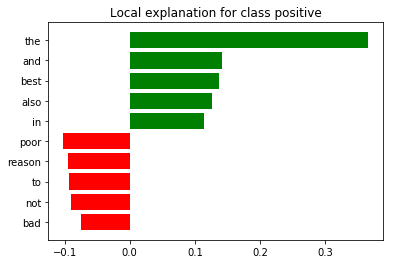

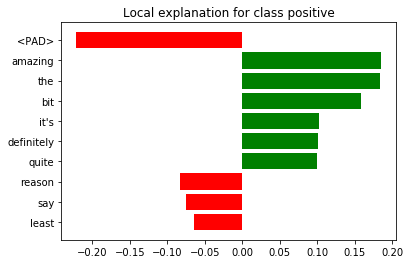

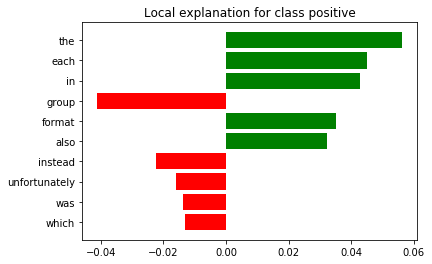

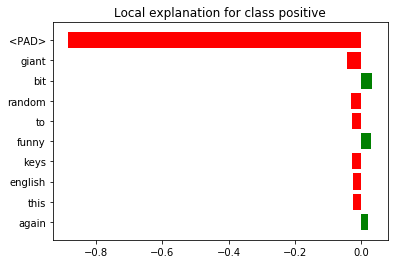

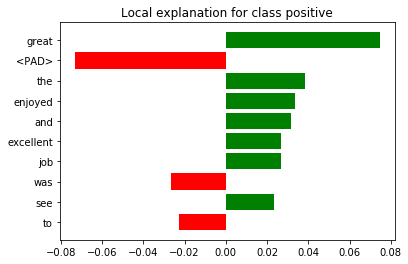

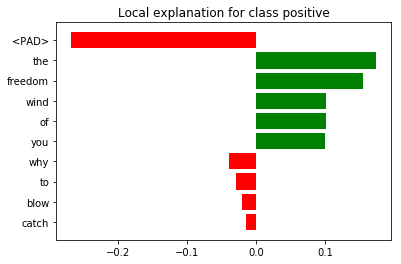

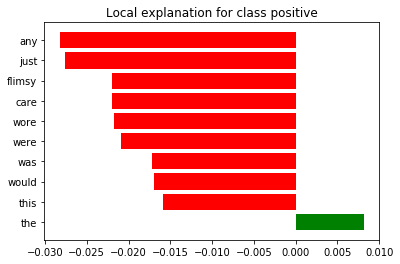

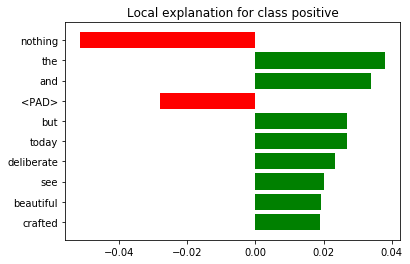

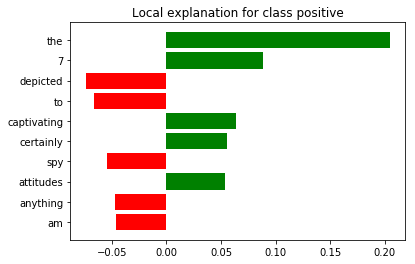

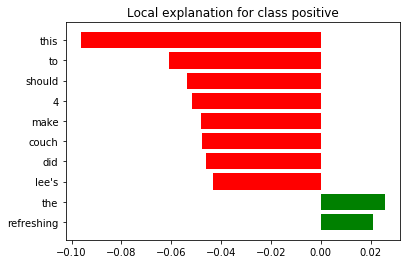

In [60]:
import matplotlib
%matplotlib inline

for text in strings_to_explain:
    exp = explainer.explain_instance(text, make_prediction)
    fig = exp.as_pyplot_figure()